# Reliability anaysis


## Packages and Helpers

In [2]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from utils import load_dataframes
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns

## Read Processed Data

In [3]:
# load overall df
all_data_unchanged = pd.read_csv("processed_data/no_change_item_data.csv")
all_data = pd.read_csv("processed_data/items_per_LLM.csv")


## Normalize item scores where tasks have different scales on different items
- AUDIT, FTND, GABS, PG

In [4]:
def normalize_per_scale(data):
    scales_to_normalize = ["AUDIT scale", "FTND scale", "GABS scale", "PG scale"]

    data = data.copy()

    # Loop over each experiment you want to normalize
    for scale in scales_to_normalize:
        mask = data["experiment"] == scale

        if mask.sum() == 0:
            continue  # skip if scale not present

        # Normalize score
        data.loc[mask, "score"] = (
            data.loc[mask, "score"] - data.loc[mask, "score"].min()
        ) / (data.loc[mask, "score"].max() - data.loc[mask, "score"].min())

        # Normalize score_top_n
        data.loc[mask, "score_top_n"] = (
            data.loc[mask, "score_top_n"] - data.loc[mask, "score_top_n"].min()
        ) / (data.loc[mask, "score_top_n"].max() - data.loc[mask, "score_top_n"].min())

    return data

all_data = normalize_per_scale(all_data)
all_data_unchanged = normalize_per_scale(all_data_unchanged)


## Chronbach's Alpha

In [5]:
# function:
def compute_cronbach_alpha(data = all_data, score = "score"):
    results = []

    # loop through experiments
    for exp, exp_data in data.groupby("experiment"):
        
        # check whether this experiment has subcategories
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            # compute alpha per category (domain)
            for domain, domain_data in exp_data.groupby("category"):
                df_wide = domain_data.pivot_table(
                    index="model", columns="item", values=score
                )
                #print(df_wide)
                if df_wide.shape[1] > 1:
                    alpha, ci = pg.cronbach_alpha(df_wide)
                else:
                    alpha, ci = None, (None, None)
                
                results.append({
                    "experiment": exp,
                    "domain": domain,
                    "alpha": alpha,
                    "alpha_CI": ci
                })
        else:
            # compute alpha for the whole experiment
            df_wide = exp_data.pivot_table(
                index="model", columns="item", values=score
            )
            #print(exp, df_wide.std().describe())
            if df_wide.shape[1] > 1:
                alpha, ci = pg.cronbach_alpha(df_wide)
            else:
                alpha, ci = None, (None, None)
            
            results.append({
                "experiment": exp,
                "domain": "total",  # no subdomain
                "alpha": alpha,
                "alpha_CI": ci
            })

    # convert to DataFrame
    return(pd.DataFrame(results))



In [28]:
reverse_item_map = pd.read_csv('processed_data/reverse_item_map.csv')

In [29]:
reverse_item_map

,expriment,pctReversed
0,AUDIT scale,0.000000
1,BARRAT scale,0.366667
2,CARE scale,0.000000
3,DAST scale,0.900000
4,Dm scale,0.000000
5,DOSPERT scale,0.000000
6,FTND scale,0.857143
7,GABS scale,0.000000
8,PG scale,1.000000
9,PRI scale,0.000000


In [ ]:
# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
alpha_df = compute_cronbach_alpha()
raw_alpha_df = compute_cronbach_alpha(data = all_data_unchanged)

# Merge raw and processed (reversed) reliability
alpha_df = alpha_df.merge(
    raw_alpha_df,
    on=["experiment", "domain"],
    how="inner",
    suffixes=("_reversed", "_raw")
)

alpha_df["reversed_higher"] = np.where(
    alpha_df["alpha_reversed"] > alpha_df["alpha_raw"], "greater",
    np.where(alpha_df["alpha_reversed"] == alpha_df["alpha_raw"], "equal", "smaller")
)


display(alpha_df)

,experiment,domain,alpha_reversed,alpha_CI_reversed,alpha_raw,alpha_CI_raw,reversed_higher
0,AUDIT scale,total,0.739466,"[0.612, 0.838]",0.934789,"[0.903, 0.96]",smaller
1,BARRAT scale,BISa,0.830566,"[0.745, 0.896]",0.973389,"[0.96, 0.984]",smaller
2,BARRAT scale,BISm,0.830683,"[0.748, 0.895]",0.965052,"[0.948, 0.978]",smaller
3,BARRAT scale,BISn,0.761134,"[0.644, 0.852]",0.975071,"[0.963, 0.985]",smaller
4,BART task,total,0.984716,"[0.977, 0.991]",0.984716,"[0.977, 0.991]",equal
5,CARE scale,CAREa,0.856412,"[0.785, 0.911]",0.856412,"[0.785, 0.911]",equal
6,CARE scale,CAREs,0.651253,"[0.468, 0.787]",0.651253,"[0.468, 0.787]",equal
7,CARE scale,CAREw,0.961134,"[0.939, 0.977]",0.961134,"[0.939, 0.977]",equal
8,CCT task,total,0.984565,"[0.977, 0.991]",0.984565,"[0.977, 0.991]",equal
9,DAST scale,total,0.503859,"[0.269, 0.69]",0.975666,"[0.964, 0.985]",smaller


In [19]:
df_wide = all_data_unchanged[all_data_unchanged["category"] == "SStas"].pivot_table(index='model', columns='item', values='score')
sorted_cols = sorted(df_wide.columns, key=lambda x: int(x))
df_wide = df_wide[sorted_cols]
correlations = df_wide.corr()
correlations

item,3,11,16,17,20,21,23,28,38,40
item,,,,,,,,,,
3,1.000000,0.717201,0.733039,0.778608,0.675498,0.617488,0.633817,0.649909,0.653454,0.612725
11,0.717201,1.000000,0.921395,0.888452,0.932651,0.914646,0.890530,0.895400,0.915741,0.869689
16,0.733039,0.921395,1.000000,0.951411,0.947995,0.935176,0.948993,0.950785,0.920992,0.893678
17,0.778608,0.888452,0.951411,1.000000,0.890100,0.905979,0.925401,0.918085,0.881976,0.895245
20,0.675498,0.932651,0.947995,0.890100,1.000000,0.946281,0.940997,0.923952,0.943848,0.886171
21,0.617488,0.914646,0.935176,0.905979,0.946281,1.000000,0.952226,0.943892,0.949189,0.898264
23,0.633817,0.890530,0.948993,0.925401,0.940997,0.952226,1.000000,0.970109,0.952210,0.940389
28,0.649909,0.895400,0.950785,0.918085,0.923952,0.943892,0.970109,1.000000,0.954122,0.926062
38,0.653454,0.915741,0.920992,0.881976,0.943848,0.949189,0.952210,0.954122,1.000000,0.940480


In [22]:
df_wide

item,3,11,16,17,20,21,23,28,38,40
model,,,,,,,,,,
Apertus-70B-Instruct-2509,1.691777,1.543207,1.502111,1.559897,1.486431,1.432895,1.457024,1.470775,1.453075,1.487347
Apertus-8B-Instruct-2509,1.360301,1.318897,1.391030,1.402201,1.307914,1.265980,1.378496,1.339187,1.249061,1.340497
Falcon-3-10B-Instruct,1.200904,1.663686,1.665474,1.516963,1.702106,1.731042,1.733538,1.682622,1.641528,1.605144
Falcon-3-1B-Instruct,1.081050,1.155037,1.203416,1.246464,1.191942,1.120053,1.266291,1.247287,1.213103,1.278724
Falcon-3-7B-Instruct,1.489312,1.316235,1.443798,1.477395,1.362127,1.380618,1.402312,1.453395,1.332037,1.356528
LFM2-1.2B,1.478084,1.527783,1.501423,1.526292,1.391645,1.394762,1.424760,1.439327,1.357898,1.453288
LFM2-2.6B,1.415921,1.265850,1.215806,1.307601,1.165695,1.161137,1.165867,1.160042,1.159449,1.213451
LFM2-8B-A1B,1.384705,1.338874,1.334925,1.318645,1.315993,1.281818,1.349390,1.372677,1.307055,1.245470
Llama-3.1-70B-Instruct,1.451595,1.484935,1.529403,1.537297,1.461359,1.547961,1.486487,1.551366,1.453070,1.451917


In [23]:
df_wide = all_data[all_data["category"] == "SStas"].pivot_table(index='model', columns='item', values='score')
sorted_cols = sorted(df_wide.columns, key=lambda x: int(x))
df_wide = df_wide[sorted_cols]
correlations = df_wide.corr()
correlations

item,3,11,16,17,20,21,23,28,38,40
item,,,,,,,,,,
3,1.000000,-0.729243,0.688903,0.654979,-0.673039,-0.664600,0.676292,0.690711,-0.680533,-0.542127
11,-0.729243,1.000000,-0.808251,-0.779816,0.905891,0.899884,-0.827549,-0.816227,0.843309,0.823005
16,0.688903,-0.808251,1.000000,0.921573,-0.828692,-0.857443,0.894406,0.863095,-0.782020,-0.751256
17,0.654979,-0.779816,0.921573,1.000000,-0.849727,-0.874727,0.896755,0.883736,-0.839475,-0.772117
20,-0.673039,0.905891,-0.828692,-0.849727,1.000000,0.950158,-0.847524,-0.830336,0.886952,0.824691
21,-0.664600,0.899884,-0.857443,-0.874727,0.950158,1.000000,-0.876728,-0.857444,0.862651,0.806070
23,0.676292,-0.827549,0.894406,0.896755,-0.847524,-0.876728,1.000000,0.942083,-0.864413,-0.827152
28,0.690711,-0.816227,0.863095,0.883736,-0.830336,-0.857444,0.942083,1.000000,-0.936918,-0.858659
38,-0.680533,0.843309,-0.782020,-0.839475,0.886952,0.862651,-0.864413,-0.936918,1.000000,0.911143


In [24]:
df_wide

item,3,11,16,17,20,21,23,28,38,40
model,,,,,,,,,,
Apertus-70B-Instruct-2509,1.604247,1.638320,1.749611,1.872377,1.558145,1.633750,1.741876,1.582498,1.699899,1.536618
Apertus-8B-Instruct-2509,1.545275,1.625676,1.717647,1.843051,1.581123,1.655891,1.734447,1.532622,1.726913,1.574656
Falcon-3-10B-Instruct,1.705864,1.370051,1.868269,1.893603,1.377786,1.486214,1.840558,1.655942,1.579433,1.386865
Falcon-3-1B-Instruct,1.556841,1.652258,1.746555,1.863774,1.589187,1.625186,1.777208,1.562194,1.666069,1.492947
Falcon-3-7B-Instruct,1.482687,1.652556,1.712461,1.850997,1.476847,1.570698,1.691343,1.504951,1.645218,1.472040
LFM2-1.2B,1.642302,1.650073,1.704818,1.861832,1.568215,1.614695,1.721454,1.553024,1.700577,1.553306
LFM2-2.6B,1.614373,1.715640,1.724477,1.812723,1.658593,1.756235,1.604997,1.414578,1.843589,1.735055
LFM2-8B-A1B,1.684763,1.617426,1.720608,1.835268,1.641628,1.692653,1.732092,1.562680,1.706022,1.588905
Llama-3.1-70B-Instruct,1.557761,1.641630,1.743743,1.866276,1.588864,1.635318,1.742524,1.554434,1.696247,1.568827


## Split-half Reliability

In [9]:
def split_half_reliability(df_items, n_splits=100):
    """Compute average split-half reliability (Spearman-Brown corrected)."""

    k = df_items.shape[1]
    
    if k < 2:
        return None, None

    cols = df_items.columns
    results = []

    for _ in range(n_splits):
        shuffled = np.random.permutation(cols)
        half1 = shuffled[:k//2]
        half2 = shuffled[k//2:]

        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)

        r, _ = pearsonr(s1, s2)

        if np.isfinite(r):
            r_sb = (2 * r) / (1 + r)  # Spearman-Brown correction
            results.append(r_sb)

    if len(results) == 0:
        return None, None
    
    return np.mean(results), np.std(results)


In [10]:
def compute_split_half_reliability(score="score"):
    rows = []  # final list of results

    for exp, exp_data in all_data.groupby("experiment"):

        # case 1: experiments with domains
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            for domain, domain_data in exp_data.groupby("category"):

                df_wide = domain_data.pivot_table(
                    index="model", columns="item", values=score
                )

                mean_rsb, sd_rsb = split_half_reliability(df_wide)

                rows.append({
                    "experiment": exp,
                    "domain": domain,
                    "split_half_mean": mean_rsb,
                    "split_half_sd": sd_rsb
                })

        # case 2: experiments without domains
        else:
            df_wide = exp_data.pivot_table(
                index="model", columns="item", values=score
            )

            mean_rsb, sd_rsb = split_half_reliability(df_wide)

            rows.append({
                "experiment": exp,
                "domain": "total",
                "split_half_mean": mean_rsb,
                "split_half_sd": sd_rsb
            })

    return pd.DataFrame(rows)


In [11]:
split_half_reliability = compute_split_half_reliability()
split_half_reliability

,experiment,domain,split_half_mean,split_half_sd
0,AUDIT scale,total,0.787094,0.083418
1,BARRAT scale,BISa,0.858314,0.092091
2,BARRAT scale,BISm,0.858908,0.085008
3,BARRAT scale,BISn,0.821303,0.113953
4,BART task,total,0.989285,0.005122
5,CARE scale,CAREa,0.990118,0.009598
6,CARE scale,CAREs,0.980483,0.018656
7,CARE scale,CAREw,0.996223,0.000747
8,CCT task,total,0.994360,0.003577
9,DAST scale,total,0.652685,0.139040


## Visualize Distributions per model

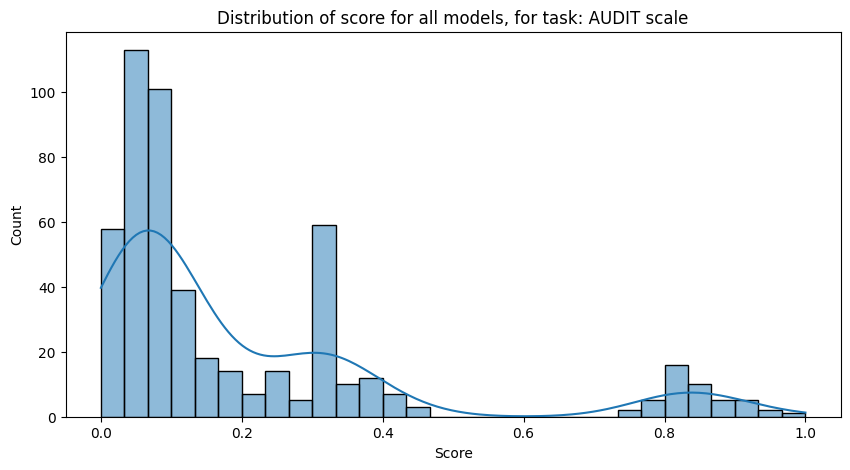

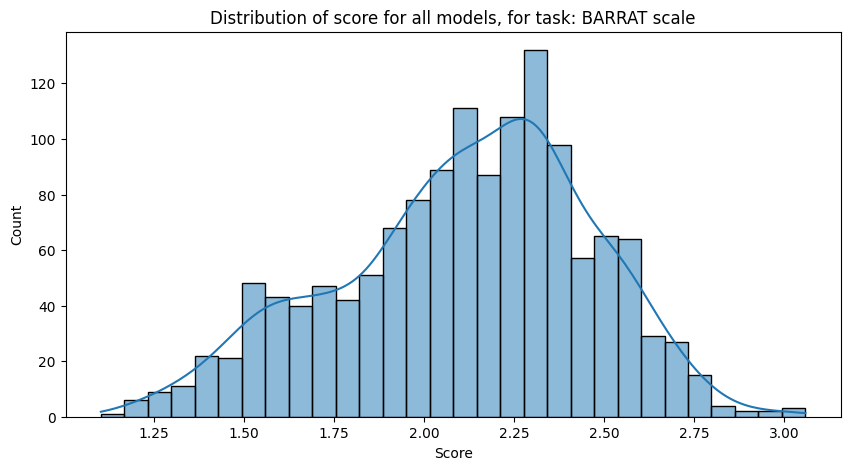

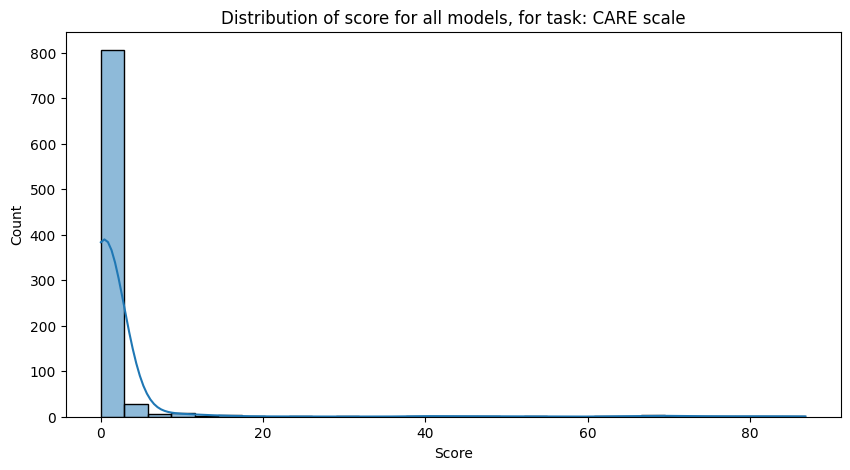

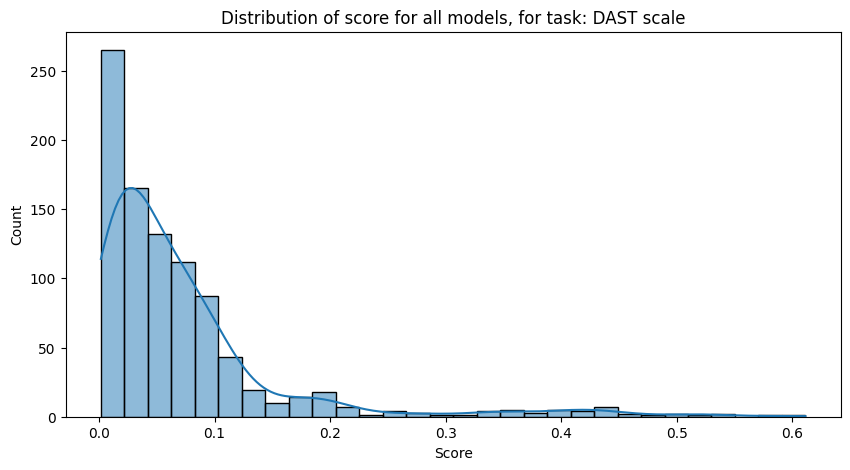

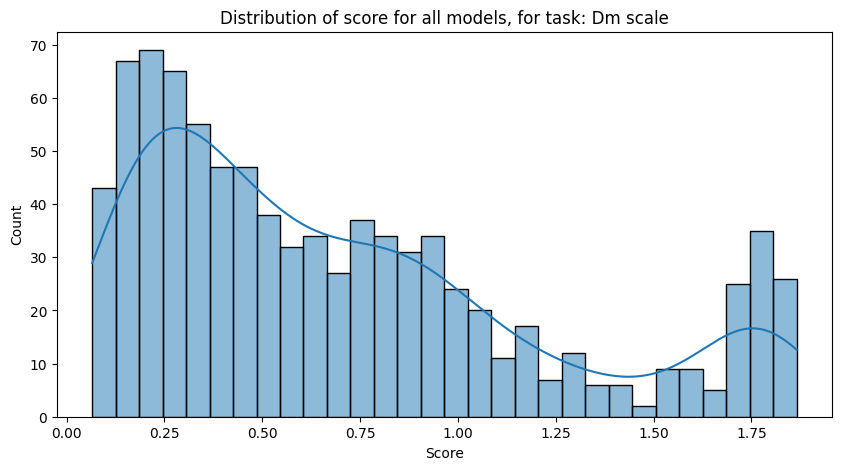

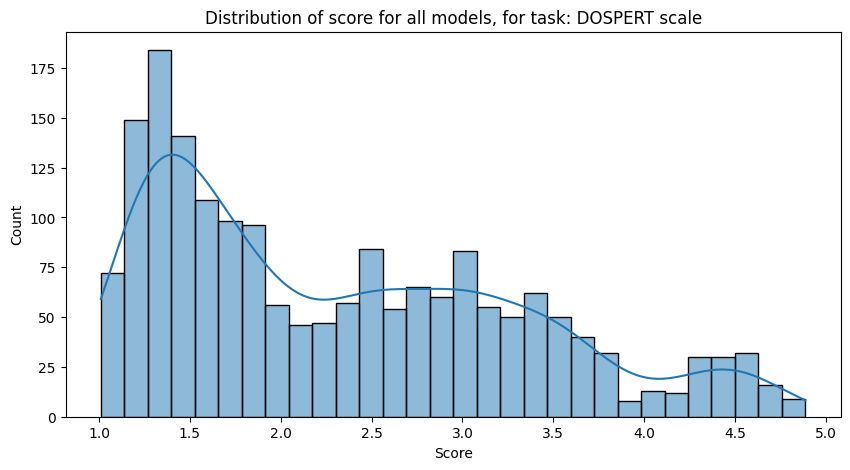

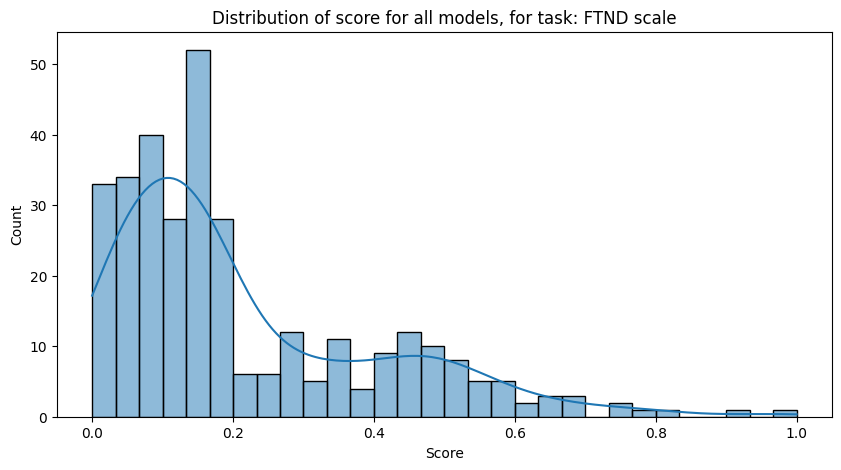

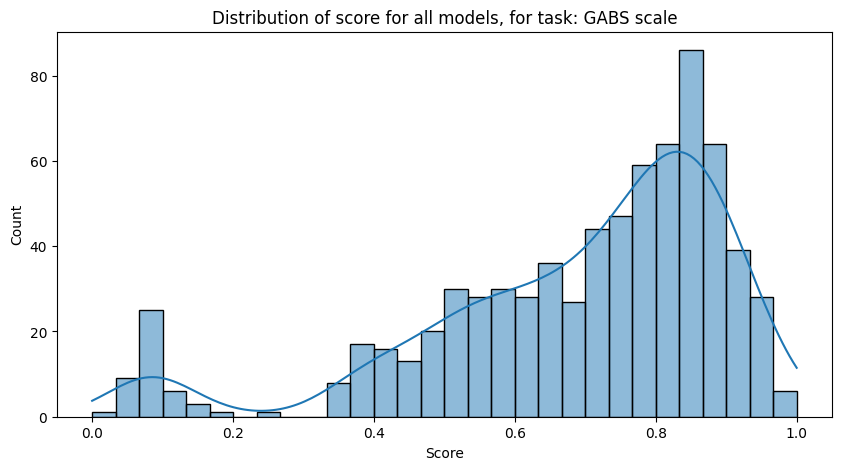

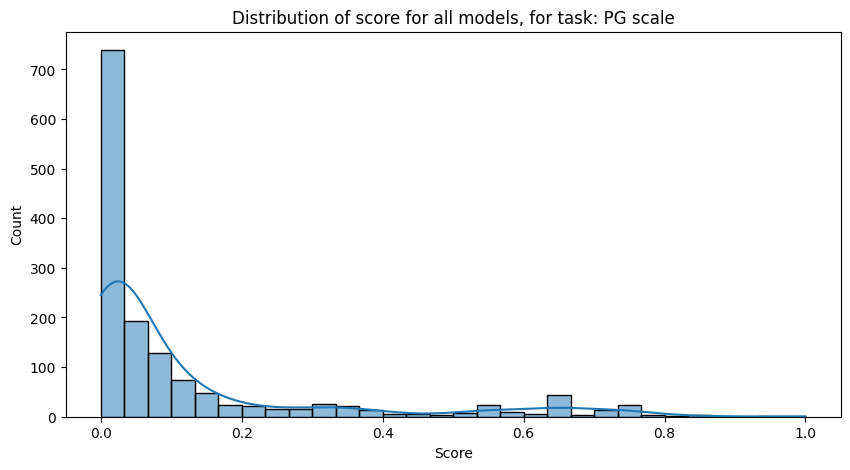

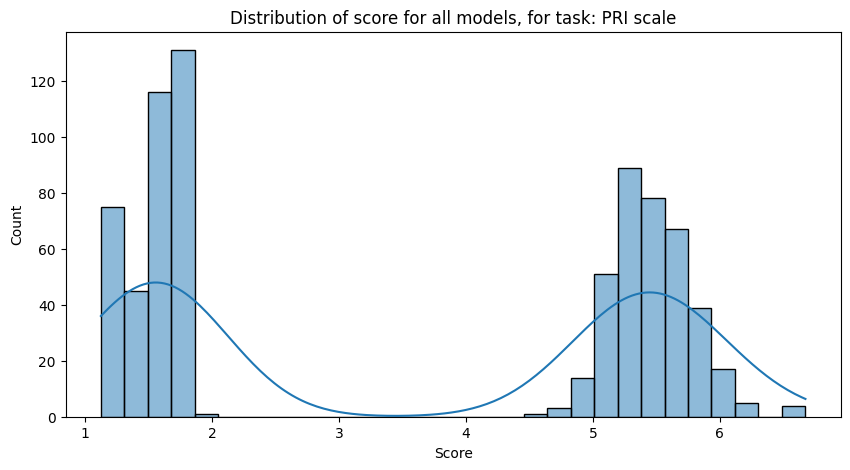

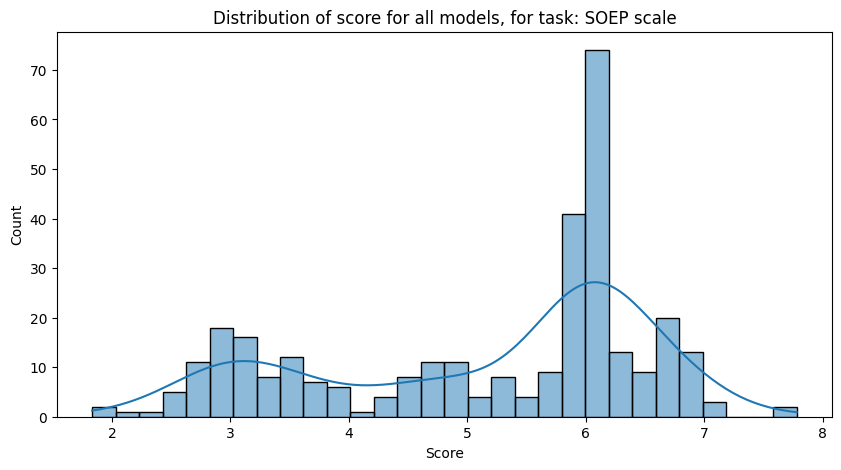

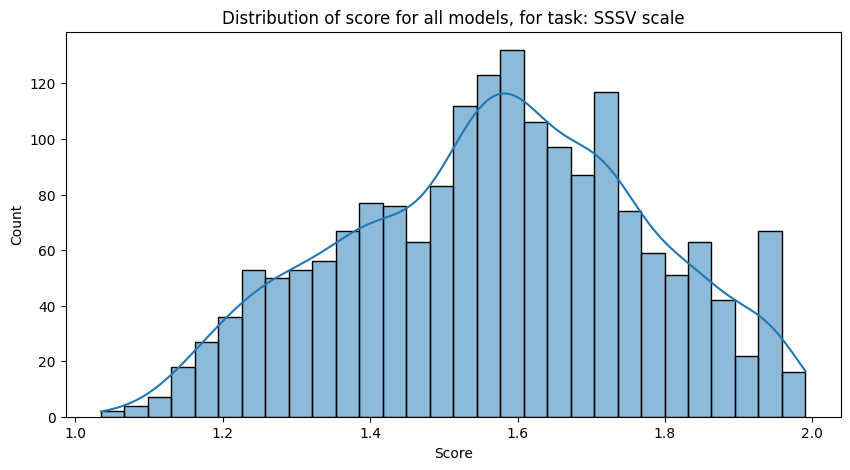

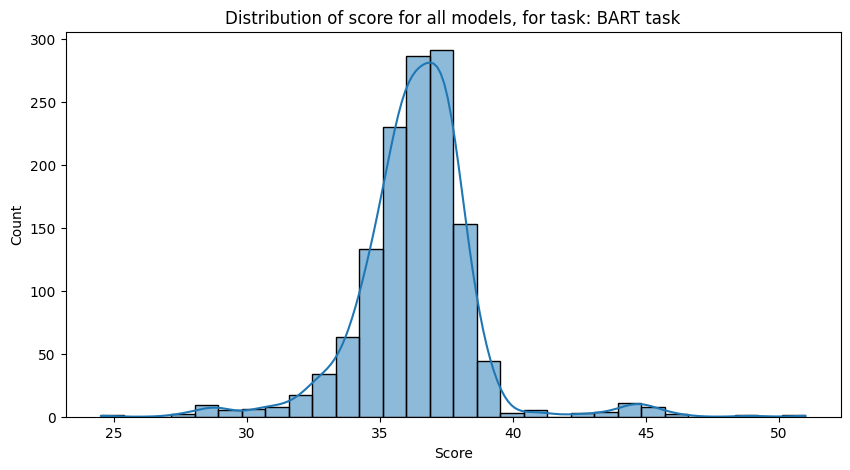

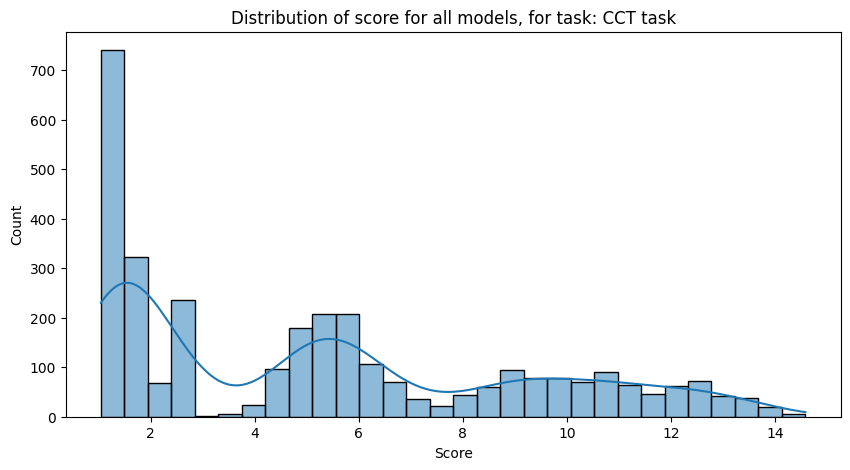

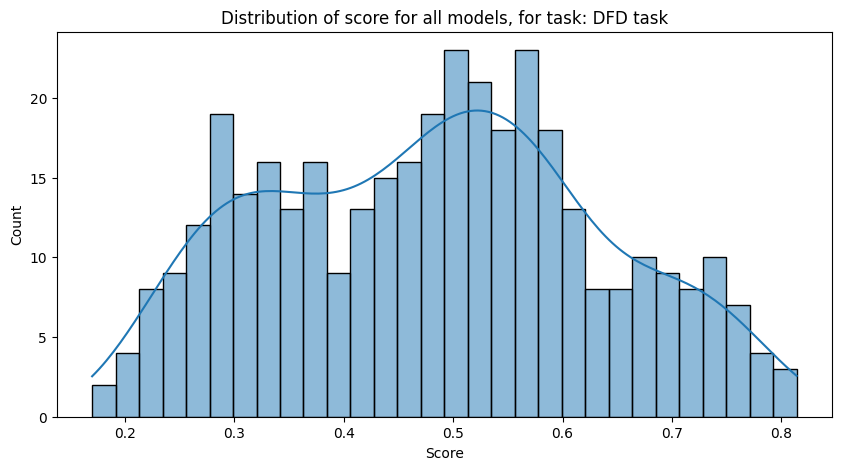

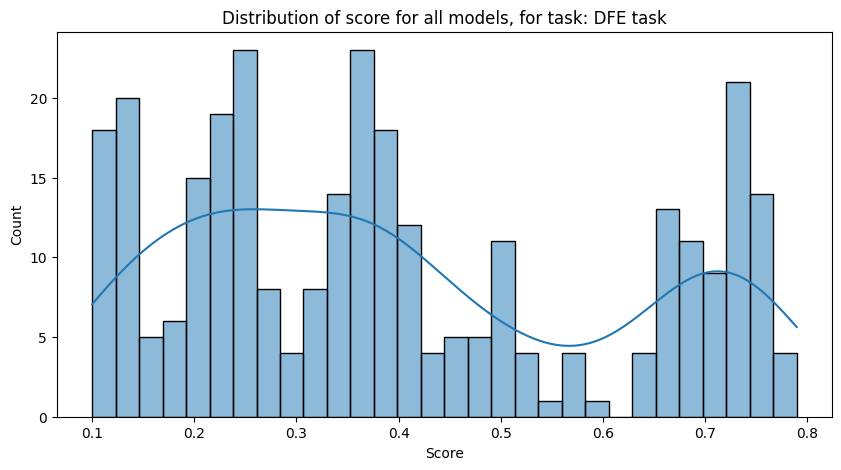

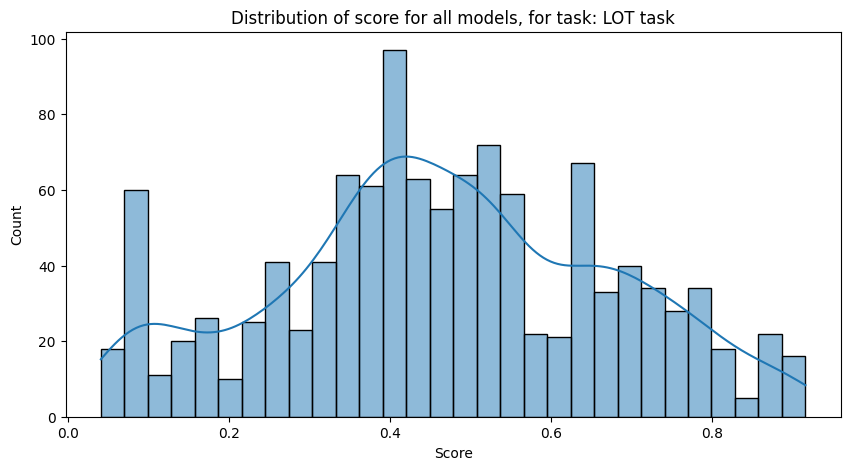

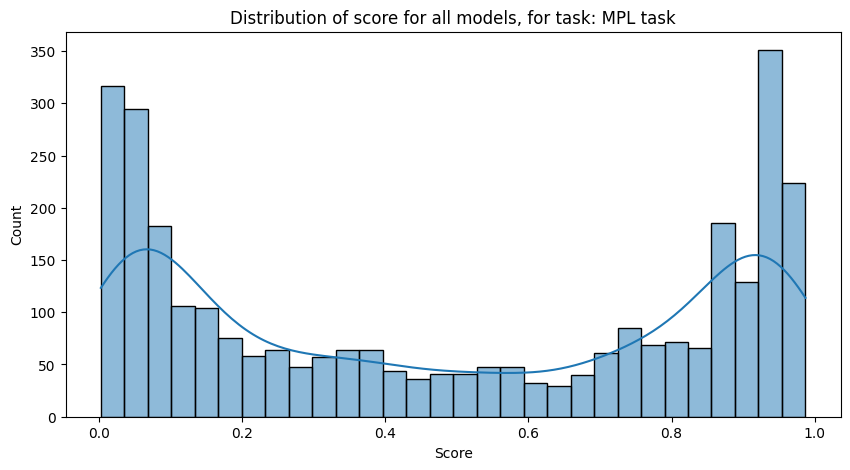

In [12]:
# Visualise distribution (focus on variance) per model of logprobs

#model_names = all_data['model'].unique()
task_names = all_data['experiment'].unique()

#for model_name in model_names:
for task_name in task_names:
    df_plot = all_data[
        #(all_data['model'] == model_name) &
        (all_data['experiment'] == task_name)
    ]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_plot, x="score", kde=True, bins=30)  
    plt.title(f'Distribution of score for all models, for task: {task_name}')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.show()